## Importing libraries

In [1]:
import os 
os.sys.path

['/Users/renanmoreira/Documents/Emob/ADAS/VehicleRecog/car_detection_forza_horizon-main',
 '/Users/renanmoreira/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles',
 '/Users/renanmoreira/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles/lib/python',
 '/Library/Frameworks/Python.framework/Versions/3.9/lib/python39.zip',
 '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9',
 '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload',
 '',
 '/Users/renanmoreira/Library/Python/3.9/lib/python/site-packages',
 '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages',
 '/Users/renanmoreira/Library/Python/3.9/lib/python/site-packages/IPython/extensions',
 '/Users/renanmoreira/.ipython']

In [2]:
import cv2
import numpy as np
import os
import time
import matplotlib.pyplot as plt

## Defining paths and loading the files of the trained model

In [3]:
pwd

'/Users/renanmoreira/Documents/Emob/ADAS/VehicleRecog/car_detection_forza_horizon-main'

In [4]:
labels_path = os.path.sep.join(['darknet/cfg/coco.names'])
LABELS = open(labels_path).read().strip().split("\n")

In [5]:
weights_path = os.path.sep.join(['darknet/yolov4.weights'])
config_path = os.path.sep.join(['darknet/cfg/yolov4.cfg'])

## Defining configurations for the detection

In [6]:
net = cv2.dnn.readNet(config_path, weights_path)

In [7]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

In [8]:
ln = net.getLayerNames()
print("All layers:")
print(ln)
print("Total: "+ str(len(ln)))
print("Output layers: ")
print(net.getUnconnectedOutLayers())
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
print(ln)

All layers:
['conv_0', 'bn_0', 'mish_1', 'conv_1', 'bn_1', 'mish_2', 'conv_2', 'bn_2', 'mish_3', 'identity_3', 'conv_4', 'bn_4', 'mish_5', 'conv_5', 'bn_5', 'mish_6', 'conv_6', 'bn_6', 'mish_7', 'shortcut_7', 'conv_8', 'bn_8', 'mish_9', 'concat_9', 'conv_10', 'bn_10', 'mish_11', 'conv_11', 'bn_11', 'mish_12', 'conv_12', 'bn_12', 'mish_13', 'identity_13', 'conv_14', 'bn_14', 'mish_15', 'conv_15', 'bn_15', 'mish_16', 'conv_16', 'bn_16', 'mish_17', 'shortcut_17', 'conv_18', 'bn_18', 'mish_19', 'conv_19', 'bn_19', 'mish_20', 'shortcut_20', 'conv_21', 'bn_21', 'mish_22', 'concat_22', 'conv_23', 'bn_23', 'mish_24', 'conv_24', 'bn_24', 'mish_25', 'conv_25', 'bn_25', 'mish_26', 'identity_26', 'conv_27', 'bn_27', 'mish_28', 'conv_28', 'bn_28', 'mish_29', 'conv_29', 'bn_29', 'mish_30', 'shortcut_30', 'conv_31', 'bn_31', 'mish_32', 'conv_32', 'bn_32', 'mish_33', 'shortcut_33', 'conv_34', 'bn_34', 'mish_35', 'conv_35', 'bn_35', 'mish_36', 'shortcut_36', 'conv_37', 'bn_37', 'mish_38', 'conv_38', 'b

In [9]:
def blob_image(net, image, show_text=True):
  start = time.time() 
  blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
  net.setInput(blob)
  layerOutputs = net.forward(ln)
  end = time.time()
  if show_text:
    print("YOLO took {:.2f} seconds".format(end - start))
  return net, image, layerOutputs

In [10]:
def detections(detection, _threshold, boxes, confidences, IDclasses):
  scores = detection[5:] 
  classID = np.argmax(scores)  
  confidence = scores[classID]

  if confidence > _threshold:
      box = detection[0:4] * np.array([W, H, W, H])     
      (centerX, centerY, width, height) = box.astype("int")
            
      x = int(centerX - (width / 2))
      y = int(centerY - (height / 2))

      boxes.append([x, y, int(width), int(height)])
      confidences.append(float(confidence))
      IDclasses.append(classID)
      
  return boxes, confidences, IDclasses

In [11]:
def image_functions(image, i, confidence, box, COLORS, LABELS, show_text=True):  
  (x, y) = (box[i][0], box[i][1])
  (w, h) = (box[i][2],box[i][3])

  color = [int(c) for c in COLORS[IDclasses[i]]]
  cv2.rectangle(image, (x, y), (x + w, y + h), color, 2) 
  text = "{}: {:.4f}".format(LABELS[IDclasses[i]], confidence[i])
  if show_text:
    print("> " + text)
    print(x,y,w,h)
  cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  return image,x,y,w,h

___

## Reading video

In [12]:
video = 'video/forza.mp4'
cap = cv2.VideoCapture(video)
connected, video = cap.read()

In [13]:
connected

True

In [14]:
video.shape

(1080, 1920, 3)

In [15]:
video_width = video.shape[1]
video_height = video.shape[0]
video_width, video_height

(1920, 1080)

___

## Resizing the video size (optional)

In [16]:
def resizing(width,height,max_width = 600): 
  if width > max_width:
    proportion = width / height
    video_width = max_width
    video_height = int(video_width / proportion)
  else:
    video_width = width
    video_height = height

  return video_width, video_height

In [17]:
threshold = 0.8
threshold_NMS = 0.5
small_font, medium_font = 0.4, 0.6
font = cv2.FONT_HERSHEY_SIMPLEX

In [18]:
samples_to_show = 20
current_sample = 0

## Output video and codec settings

In [19]:
file_name = 'result.mp4'
fourcc = cv2.VideoWriter_fourcc(*'MP4V') # MP4V

In [20]:
fps = 60

In [21]:
video_output = cv2.VideoWriter(file_name, fourcc, fps, (video_width, video_height))

## Video processing and result display

OLO took 0.85 seconds
YOLO took 0.85 seconds
YOLO took 0.94 seconds
YOLO took 0.88 seconds
YOLO took 0.90 seconds
YOLO took 0.89 seconds
YOLO took 0.90 seconds
YOLO took 0.88 seconds
YOLO took 0.87 seconds
YOLO took 0.94 seconds
YOLO took 0.91 seconds
YOLO took 0.87 seconds
YOLO took 0.85 seconds
YOLO took 0.90 seconds
YOLO took 0.88 seconds
YOLO took 0.88 seconds
YOLO took 0.88 seconds
YOLO took 0.86 seconds
YOLO took 0.89 seconds
YOLO took 0.90 seconds
YOLO took 0.89 seconds
YOLO took 0.88 seconds
YOLO took 0.87 seconds
YOLO took 0.85 seconds
YOLO took 0.85 seconds
YOLO took 0.88 seconds
YOLO took 0.90 seconds
YOLO took 0.86 seconds
YOLO took 0.87 seconds
YOLO took 0.89 seconds
YOLO took 0.89 seconds
YOLO took 0.88 seconds
YOLO took 0.87 seconds
YOLO took 0.85 seconds
YOLO took 0.88 seconds
YOLO took 0.91 seconds
YOLO took 0.86 seconds
YOLO took 0.87 seconds
YOLO took 0.91 seconds
YOLO took 0.87 seconds
YOLO took 0.88 seconds
YOLO took 0.88 seconds
YOLO took 0.85 seconds
YOLO took 0.

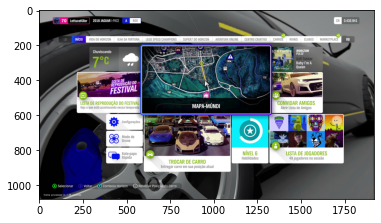

In [22]:
while (cv2.waitKey(1) < 0):
  connected, frame = cap.read() # Reading the frame of the vídeo
  if not connected:
    break
  t = time.time()
  frame = cv2.resize(frame, (video_width, video_height))
  try:
    (H, W) = frame.shape[:2]
  except:
    print('Error')
    continue

  # Results of the neural network
  image_cp = frame.copy() 
  net, frame, layerOutputs = blob_image(net, frame)
  boxes = []       
  confidences = []   
  IDclasses = []  


  # Detected object information
  for output in layerOutputs:
    for detection in output:
     boxes, confidences, IDclasses = detections(detection, threshold, boxes, confidences, IDclasses)

  objs = cv2.dnn.NMSBoxes(boxes, confidences, threshold, threshold_NMS) # Reduce bounding box keeping only the greater probability

  # Highlighting objects by creating rectangles and information
  if len(objs) > 0:
    for i in objs.flatten():
      frame, x, y, w, h = image_functions(frame, i, confidences, boxes, COLORS, LABELS, show_text=False)
      object_ = image_cp[y:y + h, x:x + w]

  
  cv2.putText(frame, " frame processed in {:.2f} seconds".format(time.time() - t), 
              (20, video_height-20), font, small_font, (250, 250, 250), 0, lineType=cv2.LINE_AA)


 
  if current_sample <= samples_to_show:
    plt.imshow(frame)
    current_sample += 1

  video_output.write(frame)

print("It's finished")
video_output.release()
cv2.destroyAllWindows()